In [1]:
%config Completer.use_jedi = False
%matplotlib inline

import os
import sys
import pytz
from datetime import datetime
import geopandas as gpd
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dask.distributed import Client
from dask import dataframe as dd

import mobilkit

## Mobilkit explanation

Here we focus our analysis on the 1st October to the 18th of November in the Mexico City and Puebla area in Mexico.

We will the show how to perform the three kind of analysis:
- home and work location (and then OD destination);
- analyze the profiles of an area before, during and after an event;
- compute the landuse of the areas.

We rely on the public and aggregated data to the `data/` folder of the `mobilkit` repository, whereas you should point the noteboook to your raw data when reading them.

Launch worker and scheduler if working on localhost with:
```
dask-worker 127.0.0.1:8786 --nprocs -1 &
dask-scheduler
```
If you get an error with `Popen` in `dask-worker`, add the option `--preload-nanny multiprocessing.popen_spawn_posix` to the first command.

In [2]:
client = Client(address="127.0.0.1:8786")
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 22.35 GiB


## Load events

Specify the path of the files to be loaded and load the df.

Note that the dataframes in dask get computed every time if not cached. It is then a good idea to cache the intermediate results (if the memry is sufficient) or persist them on disk (see below how to do that).

In [3]:
files = "/data/dataHFLB/mexico/20171*/part-*.csv.gz"

In [4]:
df = mobilkit.loader.load_raw_files(files, timezone="America/Mexico_City",
                           start_date="2017-10-01", stop_date="2017-11-18")

## Filter users

We compute the users stats. Then we show the results and decide which users to keep depending on their statistics. In particular we can filter users by their total number of pings and/or active days and by their fraction of days with at least $p$ pings (aka super-users).

For details see the starting and mid reports of the _Disaster Resilience Through Smartphone Location Data_ activity. The mid report Section 1.3 shows the overall statistics whereas Section 2 details the super user definition.

In [5]:
# We first compute the stats and then we import them in pandas to better show the features
# Since we will use it many times and it won't be huge we also persist it for convenience
users_stats_df = mobilkit.stats.userStats(df).persist()

In [8]:
# Whenever you want to get a dataframe in pandas use the .compute() method.
# WARNING use it only on aggregated dataframes and not on the RAW pings one!
users_stats_df_pd = df_usr = users_stats_df.compute()

In [9]:
# For example you can write out this dataset...
mobilkit.loader.persistDF(users_stats_df, "../data/users_stats")

# ... and reload it later
users_stats_df_reloaded = mobilkit.loader.reloadDF("../data/users_stats/*.part")

In [10]:
# Plot the 2d histogram with the pandas dataframe
# Plot not shown so as not to disclose original dataset statistics
mobilkit.stats.plotUsersHist(users_stats_df_pd, min_pings=1000, min_days=15)

## Filter users

Once we decided the minimum requirements for the users we filter the pings.
We pass the cached df to speed up things.

Here we ask that people have at least 100 pings, 15 active days and at least the 50% of them with at least 10 pings recorded.

In [17]:
df_filtered, users_stats_df, valid_users_set = mobilkit.stats.filterUsers(df, dfStats=users_stats_df,
        minPings=100, minDaysActive=15, minSuperUserDayFrac=.5, superUserPingThreshold=10)

In [18]:
print("We started with ", len(users_stats_df_pd), "users")
print("We got ", len(valid_users_set), " valid filtered users")

We started with  714808 users
We got  23654  valid filtered users


In [19]:
# Save it for convenience
pd.to_pickle(valid_users_set, "../data/valid_users.pkl")

## Tessellate

We load the files and assign, to each ping, an id of the area he is falling in. We use a reference shapefile.

Here we get an additional column with the id of the area.

See the starting report to see how the area of interest and tesselation areas have been selected.
To see how an area impact volume and activity profifles see the mid-term report Section 4.3.

In [27]:
df_zones, gdf_zones = mobilkit.spatial.tessellate(df_filtered, "../data/sample_shape/mexico_selection_epicentre.shp",
                                                  filterAreas=True)

## Persist intermediate steps

Since the tesselation computation is heavy we want to persist on disk.

In [24]:
mobilkit.loader.persistDF(df_zones, "/data/datiHFLBTiled")

In [25]:
df_zones_reloaded = mobilkit.loader.load_raw_files("/data/datiHFLBTiled/part-*.csv.gz",
                                                   sep=",", file_schema=mobilkit.dask_schemas.eventLineZone)

Filtering on accuracy <= 300


## Or reload a previously computed dataset with a given schema

Here we show how to import a dataset with an arbitrary schema.

First we define the schema, then we import the data.

It is important to use the expected column names for the relevant variables (read `mobilkit.das_schemas` for info):
- `uid` for the users id;
- `tile_ID` for the aread id;
- `lat` and `lng` for latitude and longitude;
- `UTC` for the unix time stamp;
- `datetime` for the datetime column (this will be created when using load);

Below we also show how to filter users on the go.

In [5]:
mySchema = [
    ("UTC", int),
    ("uid", str),
    ("OS", float),
    ("lat", float),
    ("lng", float),
    ("acc", float),
    ("tz", float),
    ("tile_ID", int),
]

files_pattern = "/data/datiHFLBTiled/part-00*.csv.gz"

df_zones_reloaded = mobilkit.loader.load_raw_files(pattern=files_pattern, version="csv",
            timezone="America/Mexico_City", start_date="2017-10-01", stop_date="2017-11-18",
            minAcc=300, sep=",", file_schema=mySchema)

In [177]:
# Reload good users and filter their events
valid_users_set = pd.read_pickle("../data/valid_users.pkl")

df_zones_filter = mobilkit.stats.filterUsersFromSet(df_zones_reloaded, valid_users_set)

## Compute home and work location

Here we use the default parameters but see the functions' help for details.

Specifically, we first enrich the dataset with the information on the pings belonging to home or work hours. Then we compute the number of user working or residing in each area.

Then we show how to compute the OD home-work matrix volume.

---
**NOTE**

When determining the home location of a user, please consider that some data providers, like _Cuebiq_, obfuscate/obscure/alter the coordinates of the points falling near the user's home location in order to preserve his privacy.

This means that you cannot locate the precise home of a user with a spatial resolution higher than the one used to obfuscate these data. If you are interested in the census area (or geohash) of the user's home alone and you are using a spatial tessellation with a spatial resolution wider than or equal to the one used to obfuscate the data, then this is of no concern.

However, tasks such as stop-detection or POI visit rate computation may be affected by the noise added to data in the user's home location area.

Please check if your data has such noise added and choose the spatial tessellation according to your use case.

---

In [92]:
# Reload the geodataframe for plotting
gdf_zones = gpd.read_file("../data/sample_shape/mexico_selection_epicentre.shp")

In [14]:
# Add the home/work columns
df_hw = mobilkit.stats.userHomeWork(df_zones_filter)

In [15]:
# Then compute the locations and pass them to pandas:
# - the tile_IDs of the areas of home and work;
# - the lat and lon of the home and work locations;
df_hw_locs = mobilkit.stats.userHomeWorkLocation(df_hw)
df_hw_locs_pd = df_hw_locs.compute()

In [ ]:
# Plot not shown so as not to disclose original dataset statistics
ax, gdf_residents, df_count = mobilkit.spatial.plotHomeWorkUserCount(df_hw_locs_pd, gdf_zones,
                                       what="home", kwargs_map={"vmax": 100})

In [26]:
# Save the results to file
pd.to_pickle(df_hw_locs_pd, "../data/home_work_location_counts.pkl")

In [ ]:
# Now plot the number of users residing or working in an area.
# Plot not shown so as not to disclose original dataset statistics
ax_new, gdf_residents, locs_hh = mobilkit.spatial.plotHomeWorkUserCount(df_hw_locs_pd,
                gdf_zones, what="home", kwargs_map={"cmap": "Reds", "edgecolor": "k"})

## Volume of users pings in an area

We compute the number of pings and users seen in an area in a given period and given days.

In [32]:
# This will return the data with the area id and number of pings and users
# seen in the selected time and periods.
df_act = mobilkit.stats.areaStats(df_zones_filter,
                                   start_date=None,
                                   stop_date=datetime(2018,12,31),
                                   hours=(0,24),
                                   weekdays=(2,3,4,5,6))

In [33]:
df_act_pd = df_act.compute()
df_act_pd.head(2)

,tile_ID,users,pings
0,1,1,150
1,5,1,6


In [ ]:
# Plot not shown so as not to disclose original dataset statistics
ax = mobilkit.spatial.plotActivityCount(df_act_pd, gdf_zones,
                                   what="pings",
                                   ax=None, kwargs_map={"cmap": "Reds", "vmax": "200"})

ax.set_xlim(-99.15913, -99.10032)
ax.set_ylim(19.41353, 19.46100)

## Now compute the stats of home and work

This will return, for each user and area, the total number of pings and the number of pings during home and work areas.

In [17]:
df_hw_stats = mobilkit.stats.homeWorkStats(df_hw)
df_hw_stats_pd = df_hw_stats.compute()

In [37]:
# Plot the home and work locations of a selected users
selected_user = df_hw_stats_pd.sample().reset_index().iloc[0]["uid"]

# WARNING: this is very costly as it must recompute all the dataframe
# run only if needed.
# Plot not shown so as not to disclose original dataset statistics
if False:
    ax = mobilkit.spatial.plotHomeWorkPoints(selected_user, df_hw, gdf_zones)

## Compute the OD

We simply count all the copuples of home and work locations from the `df_hw_locs_pd` dataframe.

In [38]:
OD_home_work = df_hw_locs_pd.groupby(["home_tile_ID","work_tile_ID"]).agg({"uid": "nunique"})
OD_home_work = OD_home_work.rename(columns={"uid": "Volume"})

## Monthly activity

We compute the monthly activity of the areas in terms of users and pings (and pings per users) at the hour (``timeBin``) resolution. To do so we use the ``temporal`` module and the ``computeTemporalProfile`` function.

The thing to understand is how normalization works. We have a `profile` telling the time widht of the period we want to normalize over (`"day"`, `"week"` or `"month"`) and a `normalization` scheme. The latter can be:
- `None` no normalization is done;
- `area` we compute the total number of pings and users in each area and for each period and we then normalize the number of pings and user in the (smaller or equal) ``timeBin`` temporal bin with respect to the totals of the `profile` period in the same area.
- `total` the same as before but each area gets normalized with the total number of pings and users measured in the whole region.

As we are interested in the total profiles we use all the events.

In the mid report's Section 3 we thoroughly explain all the steps presented here.

In [83]:
# Use an hourly time bin
selected_time_bin = "H"

In [84]:
df_hourly_activity_month = mobilkit.temporal.computeTemporalProfile(df_zones_reloaded,
        byArea=True, timeBin=selected_time_bin, profile="month", normalization="total")
df_hourly_activity_month_pd = df_hourly_activity_month.compute()

Now that we have the dataframe we can use seaborn to easily plot the results.

/home/ubi/Sandbox/mobilkit_dask/mobenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[]

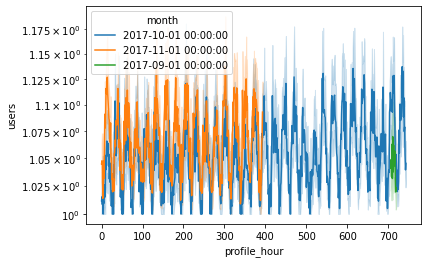

In [87]:
sns.lineplot("profile_hour", "users", hue="month",
             data=df_hourly_activity_month_pd)
plt.semilogy()

/home/ubi/Sandbox/mobilkit_dask/mobenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[]

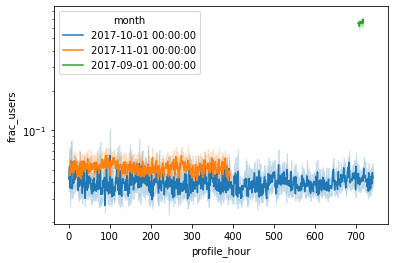

In [88]:
sns.lineplot("profile_hour", "frac_users", hue="month",
             data=df_hourly_activity_month_pd)
plt.semilogy()

## Compare the weekly activity curve in two different periods and areas.

Here I define two periods (one before and one after a given date) and save the profiles separately. Then I compare them on a weekly and daily scale.

I can also choose how to normalize the profile:
- `normalization=None` no normalization;
- `normalization="area"` normalize over the volume observed in the selected period in that area;
- `normalization="total"` normalize over the volume observed in the selected period in the whole region;

In [93]:
# We select two areas and give them different names
selected_areas_1 = mobilkit.spatial.selectAreasFromBounds(gdf_zones, relation="intersects")
area_name_1 = "Mexico City"

selected_areas_2 = mobilkit.spatial.selectAreasFromBounds(gdf_zones,
    min_lon=-98.65442, max_lon=-98.26385, min_lat=18.43240, max_lat=18.75106)
area_name_2 = "Izucar"

# We compute the weekly profiles
profile_base = "week"

# And we normalize the count by area
normalization = "area"

# Here we specify the time periods, before and after an event
datetime_format = "%Y-%m-%d %H:%M"

name_before = "Before"
time_i_before = "2017-10-23 00:00"
time_f_before = "2017-10-30 00:00"

name_after = "After"
time_i_after = "2017-10-30 00:00"
time_f_after = "2017-11-06 00:00"

Now for each area and time we compute the profiles

In [123]:
df_mex_before = mobilkit.temporal.computeTemporalProfile(df_zones_reloaded,
        byArea=True, timeBin=selected_time_bin, profile="week", normalization="area",
        start_date=time_i_before, stop_date=time_f_before, date_format=datetime_format,
        sliceName="Before", selected_areas=selected_areas_1, areasName=area_name_1)

df_mex_after = mobilkit.temporal.computeTemporalProfile(df_zones_reloaded,
        byArea=True, timeBin=selected_time_bin, profile="week", normalization="area",
        start_date=time_i_after, stop_date=time_f_after, date_format=datetime_format,
        sliceName="After", selected_areas=selected_areas_1, areasName=area_name_1)

In [124]:
df_izu_before = mobilkit.temporal.computeTemporalProfile(df_zones_reloaded,
        byArea=True, timeBin=selected_time_bin, profile="week", normalization="area",
        start_date=time_i_before, stop_date=time_f_before, date_format=datetime_format,
        sliceName="Before", selected_areas=selected_areas_2, areasName=area_name_2)

df_izu_after = mobilkit.temporal.computeTemporalProfile(df_zones_reloaded,
        byArea=True, timeBin=selected_time_bin, profile="week", normalization="area",
        start_date=time_i_after, stop_date=time_f_after, date_format=datetime_format,
        sliceName="After", selected_areas=selected_areas_2, areasName=area_name_2)

We merge them...

In [126]:
df_analysis_pd = pd.concat([d.compute() for d in
                         [df_mex_before,df_mex_after,df_izu_before,df_izu_after]],
                          ignore_index=True, sort=True)

In [ ]:
df_analysis_pd.head(2)

In [ ]:
# The raw count of pings
fig, ax = plt.subplots(1,1,figsize=(14,6))

sns.lineplot("profile_hour", "pings",
             hue="timeSlice", hue_order=["Before", "After"],
             style="areaName",
             data=df_analysis_pd,
             ax=ax,
            )

In [ ]:
# And the fraction of pings
fig, ax = plt.subplots(1,1,figsize=(14,6))

sns.lineplot("profile_hour", "frac_pings",
             hue="timeSlice", hue_order=["Before", "After"],
             style="areaName",
             data=df_analysis_pd,
             ax=ax,
            )

# Land use
## Normalized profiles, z-scores and residuals

Now compute the profiles for each area.

We limit ourselves to the workdays.

Once we have the normalized dataframe we can compute the desired indicator (average volume, z-score or residual activity) using another function of the `temporal` module.

The latter will return a set of matrices with, for each area, the volume recorded in each profile period and for each time bin plus the z-score and residual activity for that area. Moreover, it returns a set of mappings between the indexes of the matrices axes and the real values of the period, time bin and `tile_ID`, to be used later for plotting.

See Section 4 of the mid report for all the technical details.

In [183]:
# Select an area in the north-west of Mexico City
selected_areas_landuse = mobilkit.spatial.selectAreasFromBounds(gdf_zones,
    min_lon=-99.24531, max_lat=19.527744,
    max_lon=-98.99125, min_lat=19.294325,)
len(selected_areas_landuse)

2120

In [184]:
# We select the weekdays (in spark nomenclature, 1=Sunday, 7=Saturday)
# and the fact that we want normalize the activity profiles per week
weekdays = [2,3,4,5,6]
selected_profile_period = "week"

# We also want to normalize over the total volume to compare the relative fraction
# of pings present in a given area at a given time.
normalizationProfiles = "total"

In [185]:
# We cache the result as we will use it possibly many times
total_profiles_df = mobilkit.temporal.computeTemporalProfile(df_zones_reloaded,
        selected_areas=selected_areas_landuse,
        byArea=True, timeBin=selected_time_bin, profile=selected_profile_period,
        normalization=normalizationProfiles, weekdays=weekdays,).compute()

In [213]:
# Normalize the profiles on the value to aggregate
signal_column = "pings"

In [217]:
# We compute the residuals and the mappings between the matrices
# indexes and the original area, period and hour
results, mappings =  mobilkit.temporal.computeResiduals(total_profiles_df,
            signal_column=signal_column, profile=selected_profile_period)

In [219]:
# Select most active area to show the steps
most_active_area = np.argmax(results["raw"].sum(axis=1).sum(axis=1))

Here we show how to access the steps from the raw values (that have an additional axis for each profile period) to the residual activity.

Text(0, 0.5, 'pings')

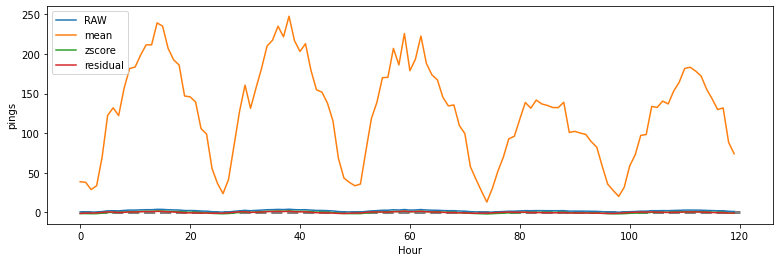

In [221]:
fig, ax = plt.subplots(1,1,figsize=(13,4))

# Normalize to compare with others...
plt.plot(results["raw"][most_active_area,:].sum(axis=0)
                         /results["raw"][most_active_area].max(), label="RAW")
plt.plot(results["mean"][most_active_area,:], label="mean")
plt.plot(results["zscore"][most_active_area,:], label="zscore")
plt.plot(results["residual"][most_active_area,:], label="residual")

plt.hlines(0, 0, 24*5, linestyles="--", color="k", alpha=.5, lw=3)

plt.legend(loc=2)

plt.xlabel("Hour")
plt.ylabel(signal_column)

### Choosing the right number of clusters

We first compute the cluster results and then we find the optimal number of clusters as the local maxima in the score curve.

In [222]:
signal_to_use = "residual"
metric = "cosine"  # The metric to be used in computing the distance matrix

In [223]:
results_clusters = mobilkit.tools.computeClusters(
    results, signal_to_use, metric=metric, nClusters=range(2,11))

Done n clusters = 02
Done n clusters = 03
Done n clusters = 04
Done n clusters = 05
Done n clusters = 06
Done n clusters = 07
Done n clusters = 08
Done n clusters = 09
Done n clusters = 10


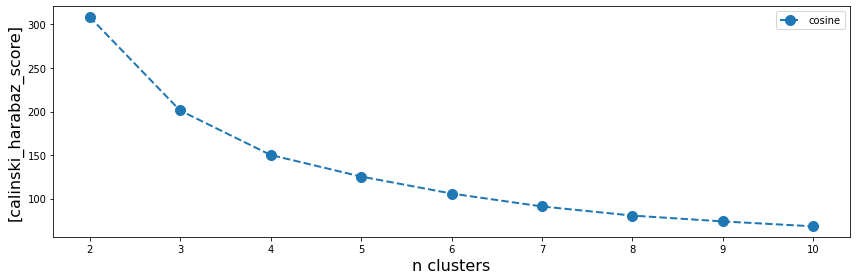

In [224]:
# Visualize score
ax_score = mobilkit.tools.checkScore(results_clusters)

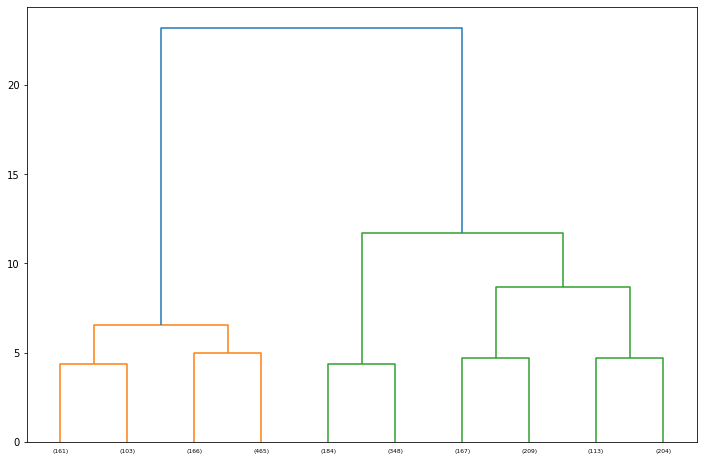

In [225]:
# Visualize the cosine dendogram...
from scipy.cluster.hierarchy import dendrogram

fig, ax = plt.subplots(1,1,figsize=(12,8))
totalDendogram = dendrogram(results_clusters["linkagesMatrix"],
                            truncate_mode='lastp', p=10, ax=ax);
plt.xticks(size=6);

Plot clusters profiles and map
We select 4 clusters and plot their profiles and map.### Plot clusters profiles and map

We select 4 clusters and plot their profiles and map.

In [226]:
nClusters = 4

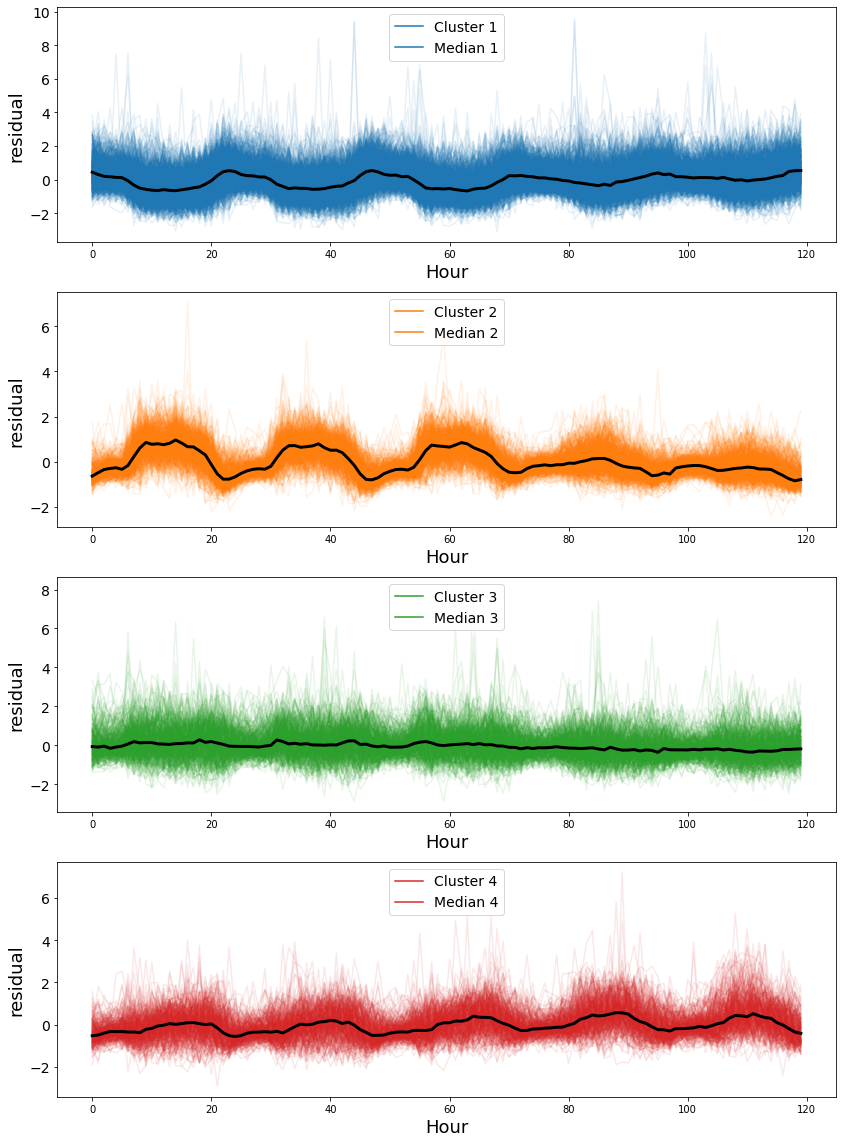

In [227]:
ax = mobilkit.tools.visualizeClustersProfiles(results_clusters,
            nClusts=nClusters, showMean=False, showMedian=True, showCurves=True)

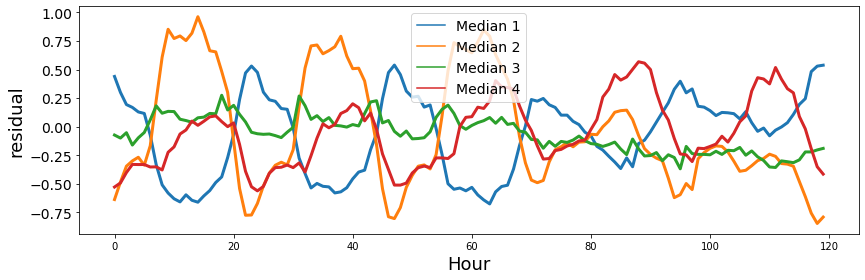

In [228]:
ax = mobilkit.tools.visualizeClustersProfiles(results_clusters,
            nClusts=nClusters, showMean=False, showMedian=True, showCurves=False, together=True)

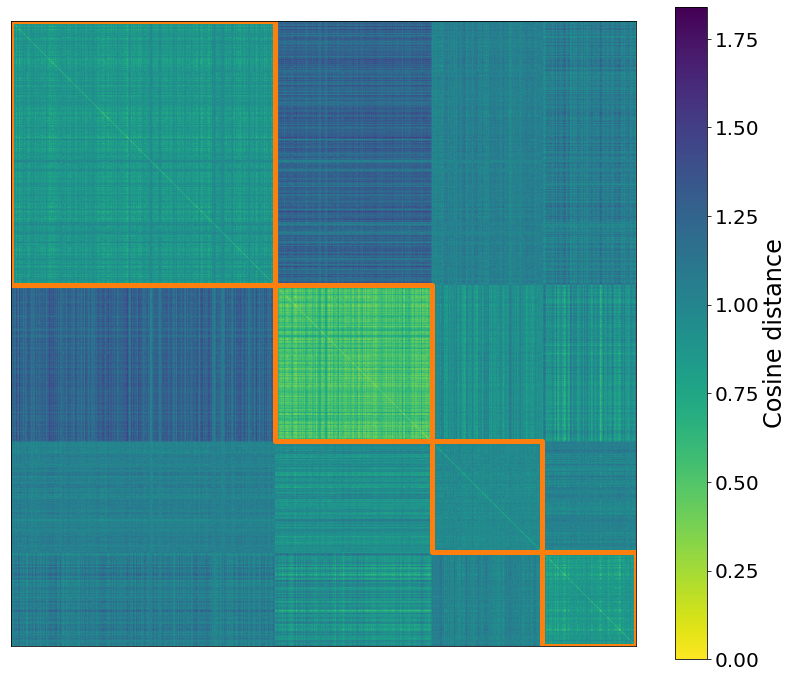

In [229]:
# The reorganized distance matrix
ax_dist = mobilkit.tools.plotCommunities(results_clusters, nClusts=nClusters)

In [230]:
# To retrieve the labels for an area we can do:
from scipy.cluster.hierarchy import fcluster

linkagesMatrix = results_clusters["linkagesMatrix"]
labels = fcluster(linkagesMatrix, nClusters, criterion="maxclust")

# And compute the area -> cluster mapping:
area_cluster = {z: labels[mappings["area2idx"][z]] for z in gdf_zones["tile_ID"]
               if z in mappings["area2idx"]}

We plot the map of the clusters, with the same colors as before.

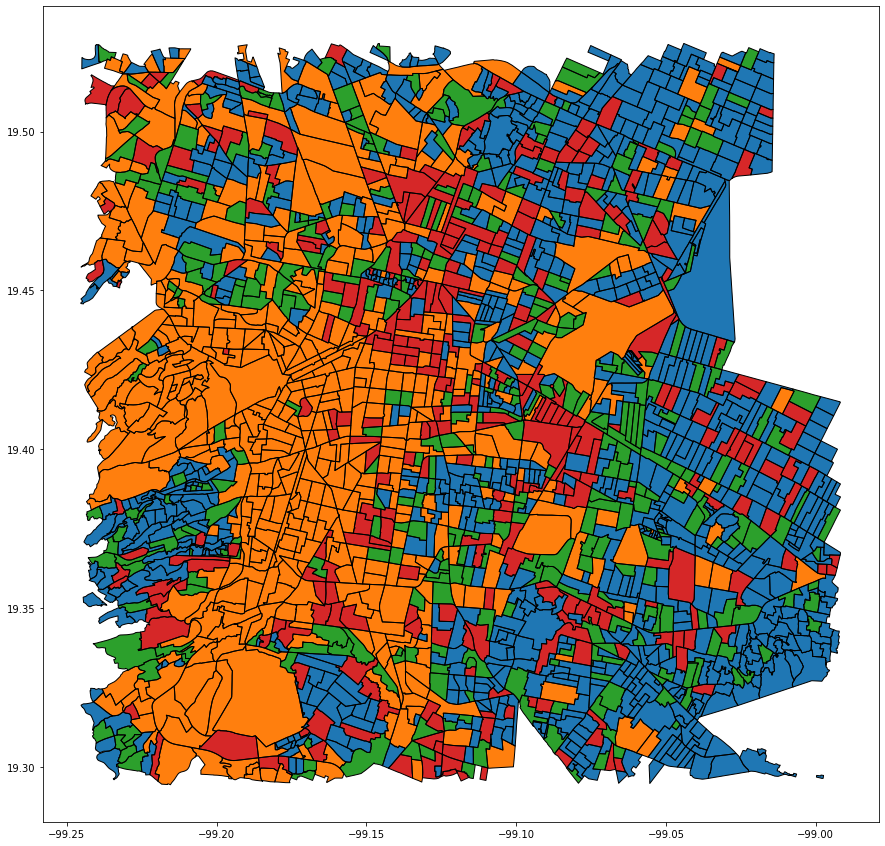

In [233]:
gdf_update, ax_mappa = mobilkit.tools.plotClustersMap(gdf_zones, results_clusters,
                                                      mappings, nClusts=nClusters)